# Breast Cancer Classification

In [ ]:
# make connection to google drive to access data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import relevant libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

%matplotlib inline

## Accessing Data Files in Google Drive

In [ ]:
# set up directory paths to image files
train_path = "/content/drive/My Drive/Deep Learning and Generative AI/breast_cancer/Dataset_BUSI_with_GT"
#val_path = "/content/drive/My Drive/Deep Learning and Generative AI/C-NMC_Leukemia/validation_data/val_data"

In [ ]:
normal_imgs = [] # store normal cell image names
cancer_imgs = [] # store cancer cell image names

for file in os.listdir(train_path+"/normal"): # normal cells
  if 'mask' not in file:
    normal_imgs.append(file)
for file in os.listdir(train_path+"/malignant"): # cancer cells
  if 'mask' not in file:
    cancer_imgs.append(file)

In [ ]:
len(normal_imgs), len(cancer_imgs)

(133, 210)

(574, 690, 3)


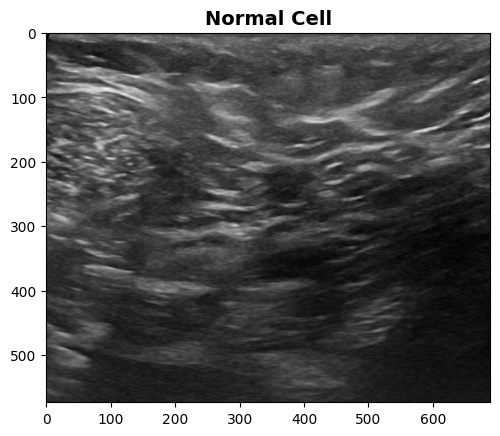

In [ ]:
image_path = os.path.join(train_path+"/normal",normal_imgs[2]) # create the full path to the image
img = mpimg.imread(image_path) # read the image data
print(img.shape) # print the shape of the image data
plt.imshow(img) # display the image data
plt.title("Normal Cell", fontsize=14, fontweight='bold')
plt.show()

(393, 462, 3)


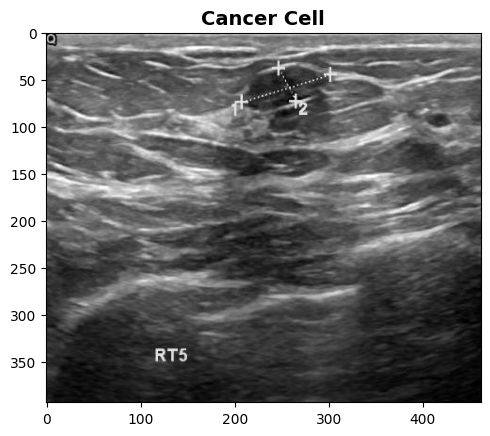

In [ ]:
image_path = os.path.join(train_path+"/malignant", cancer_imgs[2]) # create the full path to the image
img = mpimg.imread(image_path) # read the image data
print(img.shape) # print the shape of the image data
plt.imshow(img) # display the image data
plt.title("Cancer Cell", fontsize=14, fontweight='bold')
plt.show()

## Image Preprocessing

In [ ]:
dim1 = [] # storing first dimensions of image for analysis
dim2 = [] # storing second dimensions of image for analysis

for image_filename in os.listdir(train_path+'/normal'): # parse through all non-cancer images
    if 'mask' not in image_filename:
      img = mpimg.imread(train_path+'/normal'+'/'+image_filename) # convert image to array
      d1,d2,colors = img.shape # get dimensions of image
      dim1.append(d1) # append to dimension 1 list
      dim2.append(d2) # append to dimension 2 list

for image_filename in os.listdir(train_path+'/malignant'): # parse through all cancer images
    if 'mask' not in image_filename:
      img = mpimg.imread(train_path+'/malignant'+'/'+image_filename) # convert image to array
      d1,d2,colors = img.shape # get dimensions of image
      dim1.append(d1) # append to dimension 1 list
      dim2.append(d2) # append to dimension 2 list

In [ ]:
# check for variations in dimensions
np.mean(dim1),np.mean(dim2)

(509.0728862973761, 618.600583090379)

In [ ]:
# standard shape of image
image_shape = (226,226,1)

In [ ]:
# import library for image manipulation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
def preprocess_image(x):
    if 'mask' not in x:
      return x
    else:
      return None

In [ ]:
# set up generator for image manipulation to add diversity in dataset
image_gen = ImageDataGenerator(rotation_range=20, # rotate 20 degrees
                               width_shift_range=0.10, # shift width by max of 5%
                               height_shift_range=0.10, # shift height by max of 5%
                               rescale=1/255, # rescale image by normalzing
                               shear_range=0.1, # cutting part of image (max 10%)
                               zoom_range=0.1, # zoom by 10% max
                               horizontal_flip=True, # horizontal flip
                               fill_mode='nearest', # fill missing pixels with nearest filled value
                               preprocessing_function=preprocess_image # preprocess image
                              )

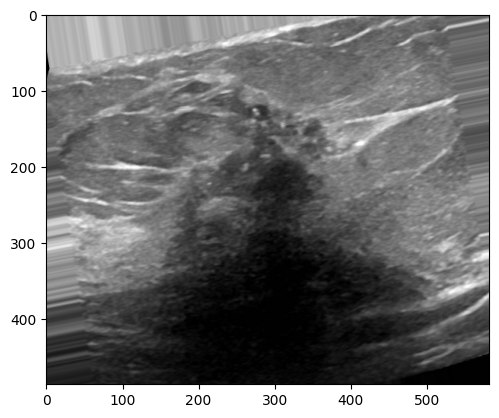

In [ ]:
# rerun this cell as an example of how image is transformed
plt.imshow(image_gen.random_transform(img))

## Convolutional Neural Network Model for Image Classification

In [ ]:
# import relevant libraries from tensor flow for model construction
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()  # make sequential model

# add convolutional layers with pooling layers (max pooling)
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten output
model.add(Flatten())

# add batch normalization
model.add(BatchNormalization())

# add layer of neurons with 'relu' activation
model.add(Dense(128))
model.add(Activation('relu'))

# add dropout layer, rate=0.5
model.add(Dropout(0.6))

# final output neuron for prediction (cancer or not cancer) with 'sigmoid' activation
model.add(Dense(1))
model.add(Activation('sigmoid'))

# compile model with 'ADAM' optimizer
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# prints out model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 110, 110, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 55, 55, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 53, 53, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 86528)               │         346,112 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,514,625 (43.92 MB)

 Trainable params: 11,341,569 (43.26 MB)

 Non-trainable params: 173,056 (676.00 KB)

In [ ]:
# early stopping to monitor validation loss for no improvement
early_stop = EarlyStopping(monitor='loss',patience=5)

In [ ]:
batch_size = 32 # to train in batches

In [ ]:
# generator to get train images from directory and manipulate
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=(224,224),
                                                color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 687 images belonging to 2 classes.


In [ ]:
train_image_gen.class_indices # check labels of data

{'malignant': 0, 'normal': 1}

In [ ]:
# suppress any warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# fit the model on dataset
results = model.fit(train_image_gen,epochs=20,callbacks=[early_stop])

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.5301 - loss: 1.0326
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.7092 - loss: 0.4758
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.8401 - loss: 0.3607
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.8176 - loss: 0.3525
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.8383 - loss: 0.3272
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.8801 - loss: 0.2761
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.8470 - loss: 0.3095
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.8755 - loss: 0.2854
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.8553 - loss: 0.2703
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.8756 - loss: 0.2811
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.8916 - loss: 0.2412
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.9017 -

In [ ]:
# # save entire CNN model
# model.save('cnn_unbalanced_model.keras')

In [ ]:
# # save weights separately
# model.save_weights('cnn_unbalanced_weights.weights.h5')

In [ ]:
# # import relevant library to store model history as json file
# import json
# with open('cnn_unbalanced_history.json', 'w') as f:
#     json.dump(results.history, f)

In [ ]:
# # save model architecture to JSON
# with open("cnn_unbalanced_architecture.json", "w") as json_file:
#     json_file.write(model.to_json())

## Model Evaluation

In [ ]:
# store results as dataframe
losses = pd.DataFrame(model.history.history)

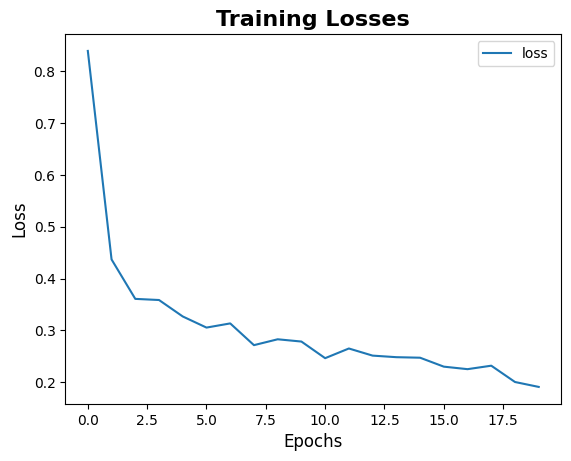

In [ ]:
# plot training and validation losses
ax = losses[['loss']].plot()

# set title and labels
ax.set_title('Training Losses', fontsize=16, fontweight='bold')
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)

plt.show()

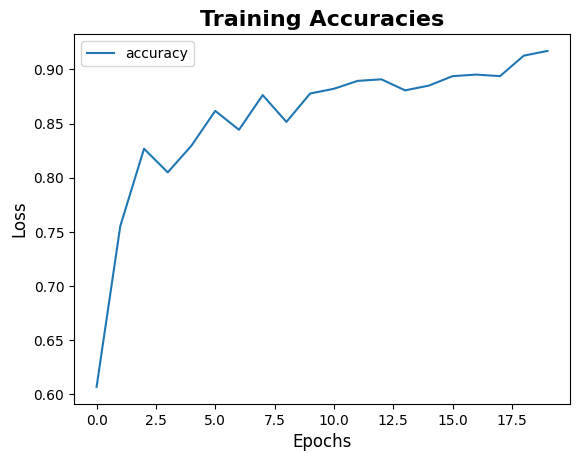

In [ ]:
# plot training and validation accuracies
ax = losses[['accuracy']].plot()

# set title and labels
ax.set_title('Training Accuracies', fontsize=16, fontweight='bold')
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)

plt.show()

In [ ]:
# metrics that were analyzed during fitting
model.metrics_names

['loss', 'compile_metrics']

In [ ]:
# example evaluation on validation dataset to get those metrics
model.evaluate(train_image_gen)

22/22 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6591 - loss: 0.4059


[0.4142006039619446, 0.6521106362342834]

In [ ]:
# predict on validation dataset
pred_probabilities = model.predict(train_image_gen)

22/22 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step


In [ ]:
# classify predictions in binary method
predictions = pred_probabilities > 0.5
# predictions = (pred > 0.5).astype('int') # another way to do it

In [ ]:
train_image_gen.classes # check labels of data

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
# import relevant libraries for classification metrics and quantitative analysis
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
# print classification report to understand key metrics
print(classification_report(train_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.61      0.96      0.75       421
           1       0.32      0.03      0.05       266

    accuracy                           0.60       687
   macro avg       0.46      0.50      0.40       687
weighted avg       0.50      0.60      0.48       687



In [ ]:
# print confusion matrix to investigate accurate predictions
print(confusion_matrix(train_image_gen.classes,predictions))

[[406  15]
 [259   7]]


In [ ]:
# get confusion matrix
cm = confusion_matrix(train_image_gen.classes,predictions)

# extract True Positives, False Negatives, False Positives, True Negatives
TN, FP, FN, TP = cm.ravel()

# calculate sensitivity and specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Sensitivity: 0.0263
Specificity: 0.9644


AUC-ROC Score: 0.49534317


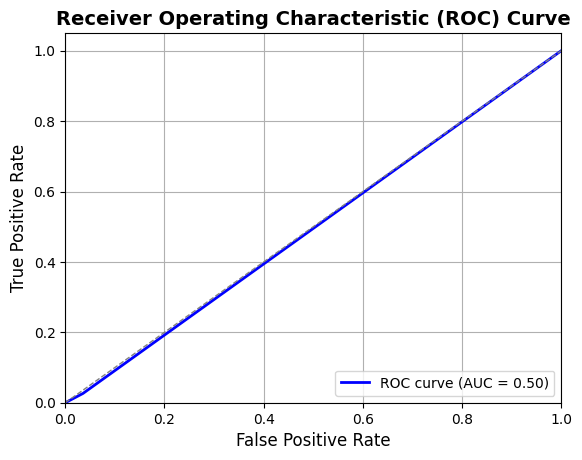

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# calculate AUC-ROC score
auc_roc = roc_auc_score(train_image_gen.classes,predictions)
print(f"AUC-ROC Score: {auc_roc:.8f}")

# compute ROC curve
fpr, tpr, thresholds = roc_curve(train_image_gen.classes,predictions)

# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=12)
plt.ylabel('True Positive Rate',fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve',fontsize=14,fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Prediction on Testing Data

In [ ]:
# import relevant library for image analysis
from tensorflow.keras.preprocessing import image

In [ ]:
train_imgs = [] # list to store all training image names

for file in os.listdir(train_path+'/normal'): # parse through training directory and get all normal cell images
    if 'mask' not in file:
      train_imgs.append(file)

In [ ]:
# load an example image - can change number
my_image = image.load_img(os.path.join(train_path+'/normal',train_imgs[3]),target_size=image_shape)

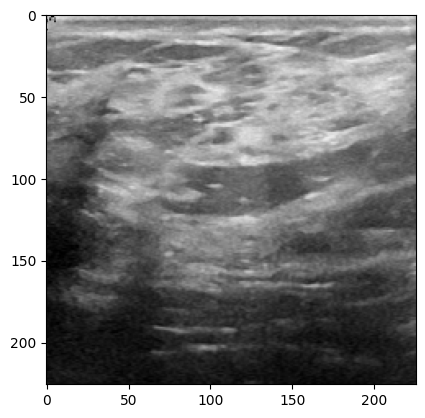

In [ ]:
# plot to see the image of cell
plt.imshow(my_image)

In [ ]:
my_image = image.img_to_array(my_image) # convert from image file to array for prediction

In [ ]:
my_image.shape # check shape of image array

(226, 226, 3)

In [ ]:
my_image = np.expand_dims(my_image, axis=0) # expand dimension to make it compatible as model input

In [ ]:
my_image.shape # recheck shape of image array

(1, 226, 226, 3)

In [ ]:
model.predict(my_image) # make prediction on current selected cell - should be normal

In [ ]:
train_image_gen.class_indices # definition of indices